#**유통 판매량 예측 및 재고 최적화**
## **단계2 : 모델링을 위한 데이터 전처리**

# **0.미션**

* 단계1 상품별 데이터셋 만들기
    * 가설로 도출된 변수를 반영한 데이터셋을 상품별로 생성
* 단계2 기초 모델 생성
    * base line model : dense layer만 이용해서 기초 모델 생성
    * LSTM, CNN 알고리즘을 이용해서 기초 모델 생성

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

### **(2) 라이브러리 설치 및 불러오기**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [3]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

In [4]:
oil_price = pd.read_csv('train/oil_price_train.csv')
orders = pd.read_csv('train/orders_train.csv')
sales = pd.read_csv('train/sales_train.csv')
products = pd.read_csv('train/products.csv')
stores = pd.read_csv('train/stores.csv')
dataset = pd.read_csv('Merged_Datset.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

# **2.데이터셋 구성하기**

* 세부 요구사항
    * 상품코드 별로 각각 데이터셋을 구성해야 합니다.
    * 도출된 변수들을 포함하는 데이터셋을 구성합니다.


In [5]:
dataset.loc[(dataset['Store_ID']==44) & (dataset['Product_ID']==42)]

,Unnamed: 0,Date,Store_ID,Qty,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price,City,State,Store_Type,WTI_Price,CustomerCount
658,658,2014-01-01,44,51.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,NaN,NaN
1469,1469,2014-01-02,44,76.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,95.14,4422.0
2280,2280,2014-01-03,44,74.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,93.66,4167.0
3091,3091,2014-01-04,44,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,NaN,5341.0
3902,3902,2014-01-05,44,88.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,NaN,5123.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
930878,930878,2017-02-24,44,91.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,53.99,4549.0
931689,931689,2017-02-25,44,105.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,NaN,4619.0
932500,932500,2017-02-26,44,108.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,NaN,3877.0
933311,933311,2017-02-27,44,78.0,42,FM001,Agricultural products,Grocery,2,5,Saint Paul,\tMinnesota,1,54.04,3961.0


In [6]:
myinterested = dataset.loc[(dataset['Store_ID']==44) & (dataset['Product_ID']==42)]
myinterested.drop(columns=['Unnamed: 0','Product_Code','Store_Type','SubCategory','Category','Store_ID','Product_ID','State','City','LeadTime'],inplace=True) # 학습에 도움이 될 것 같지 않은 column은 삭제
myinterested.reset_index(drop=True,inplace=True) # 인덱스 번호 초기화
myinterested['Qty'].astype(int)
myinterested

,Date,Qty,Price,WTI_Price,CustomerCount
0,2014-01-01,51.0,5,NaN,NaN
1,2014-01-02,76.0,5,95.14,4422.0
2,2014-01-03,74.0,5,93.66,4167.0
3,2014-01-04,78.0,5,NaN,5341.0
4,2014-01-05,88.0,5,NaN,5123.0
...,...,...,...,...,...
1150,2017-02-24,91.0,5,53.99,4549.0
1151,2017-02-25,105.0,5,NaN,4619.0
1152,2017-02-26,108.0,5,NaN,3877.0
1153,2017-02-27,78.0,5,54.04,3961.0


## **(1) 상품 : 42 - Agricultural products**

In [7]:
myinterested # 외부적요인 WTI_Price (유가)가 상품 판매량에 끼치는 요인이 될 수 있을까? 의문
myinterested['Date'] = pd.to_datetime(myinterested['Date'])
myinterested.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1155 entries, 0 to 1154
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1155 non-null   datetime64[ns]
 1   Qty            1155 non-null   float64       
 2   Price          1155 non-null   int64         
 3   WTI_Price      795 non-null    float64       
 4   CustomerCount  1146 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 45.2 KB


In [8]:
myinterested['year'] = myinterested['Date'].dt.year
myinterested['weekday'] = myinterested['Date'].dt.weekday
myinterested['month'] = myinterested['Date'].dt.month
 
# 미국 연방 공휴일 기준
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays()

myinterested['holiday'] = np.where((myinterested['weekday'] >= 5) | (myinterested['Date'].isin(holidays)), 1, 0)
myinterested

,Date,Qty,Price,WTI_Price,CustomerCount,year,weekday,month,holiday
0,2014-01-01,51.0,5,NaN,NaN,2014,2,1,1
1,2014-01-02,76.0,5,95.14,4422.0,2014,3,1,0
2,2014-01-03,74.0,5,93.66,4167.0,2014,4,1,0
3,2014-01-04,78.0,5,NaN,5341.0,2014,5,1,1
4,2014-01-05,88.0,5,NaN,5123.0,2014,6,1,1
...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91.0,5,53.99,4549.0,2017,4,2,0
1151,2017-02-25,105.0,5,NaN,4619.0,2017,5,2,1
1152,2017-02-26,108.0,5,NaN,3877.0,2017,6,2,1
1153,2017-02-27,78.0,5,54.04,3961.0,2017,0,2,0


월마다 판매량 차이가 존재하는가? 

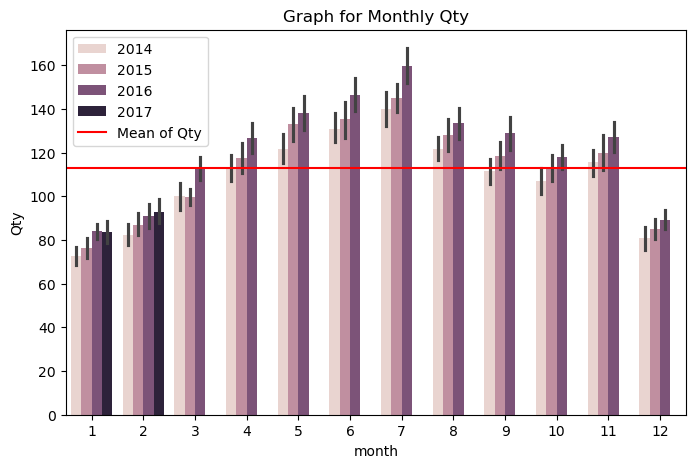

In [9]:
plt.figure(figsize=(8,5))
sns.barplot(myinterested,y='Qty',x='month',hue='year')
plt.axhline(myinterested['Qty'].mean(),color='red',label='Mean of Qty')
plt.legend()
plt.title('Graph for Monthly Qty') # 4월,5월,6월,7월,8월
plt.show()

# 공휴일 | 평일의 Qty(판매량) 차이

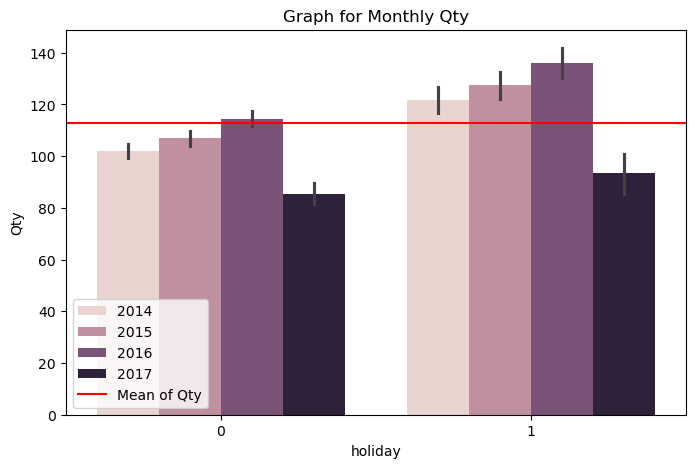

In [10]:
plt.figure(figsize=(8,5))
sns.barplot(myinterested,y='Qty',x='holiday',hue='year')
plt.axhline(myinterested['Qty'].mean(),color='red',label='Mean of Qty')
plt.legend()
plt.title('Graph for Monthly Qty') # 판매량 차이
plt.show()

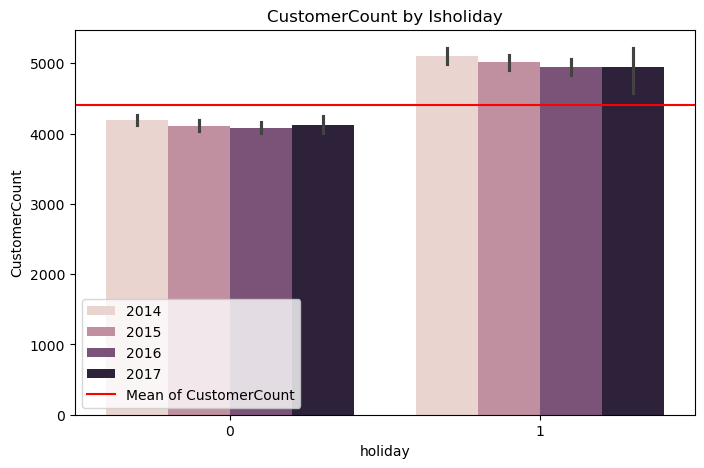

In [11]:
plt.figure(figsize=(8,5))
sns.barplot(myinterested,y='CustomerCount',x='holiday',hue='year')
plt.axhline(myinterested['CustomerCount'].mean(),color='red',label='Mean of CustomerCount')
plt.legend()
plt.title('CustomerCount by Isholiday') # 
plt.show()

In [12]:
myinterested['OverQtyMonth'] = myinterested['month'].map({1:0,2:0,3:0,4:1,5:1,6:1,7:1,8:1,9:1,10:1,11:1,12:0}) # 판매량 평균을 넘어가는 달에 대해 추가 칼럼으로 0,1을 만들어주었다.
myinterested['Summer'] = myinterested['month'].map({5:1,6:1,7:1,8:1,1:0,2:0,3:0,4:0,9:0,10:0,11:0,12:0}) # 여름에 잘 팔리는 상품인 것 같아서 여름인가? 에 대한 칼럼을 추가로 만들어줌
myinterested['WTI_Price'] = myinterested['WTI_Price'].bfill() # 유가 데이터는 주변 데이터와 비슷하거나 동일할 것이라고 생각되어 bbfill 근접한 데이터를 사용해서 채워줌

In [13]:
from sklearn.impute import KNNImputer 
imputer = KNNImputer(n_neighbors=3)
myinterested['CustomerCount'] = imputer.fit_transform(myinterested[['Qty','CustomerCount','holiday']])[:,1] # 위에서 공휴일과 아닐때의 방문 차이가 있으니 공휴일과 판매량도 고려해서 결측치 해결
myinterested[['CustomerCount','Qty']] = myinterested[['CustomerCount','Qty']].astype(int)
myinterested = myinterested.rename(columns= {'holiday':'IsHoliday','Summer':'IsSummer','OverQtyMonth':'IsOverQtyMonth'})
myinterested

,Date,Qty,Price,WTI_Price,CustomerCount,year,weekday,month,IsHoliday,IsOverQtyMonth,IsSummer
0,2014-01-01,51,5,95.14,3865,2014,2,1,1,0,0
1,2014-01-02,76,5,95.14,4422,2014,3,1,0,0,0
2,2014-01-03,74,5,93.66,4167,2014,4,1,0,0,0
3,2014-01-04,78,5,93.12,5341,2014,5,1,1,0,0
4,2014-01-05,88,5,93.12,5123,2014,6,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91,5,53.99,4549,2017,4,2,0,0,0
1151,2017-02-25,105,5,54.04,4619,2017,5,2,1,0,0
1152,2017-02-26,108,5,54.04,3877,2017,6,2,1,0,0
1153,2017-02-27,78,5,54.04,3961,2017,0,2,0,0,0


# 가격고려 Feature 추가 (파생변수)

In [14]:
myinterested['TotalPrice'] = myinterested['Price']*myinterested['Qty']
myinterested.drop(columns='Price',inplace=True)
myinterested

,Date,Qty,WTI_Price,CustomerCount,year,weekday,month,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice
0,2014-01-01,51,95.14,3865,2014,2,1,1,0,0,255
1,2014-01-02,76,95.14,4422,2014,3,1,0,0,0,380
2,2014-01-03,74,93.66,4167,2014,4,1,0,0,0,370
3,2014-01-04,78,93.12,5341,2014,5,1,1,0,0,390
4,2014-01-05,88,93.12,5123,2014,6,1,1,0,0,440
...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91,53.99,4549,2017,4,2,0,0,0,455
1151,2017-02-25,105,54.04,4619,2017,5,2,1,0,0,525
1152,2017-02-26,108,54.04,3877,2017,6,2,1,0,0,540
1153,2017-02-27,78,54.04,3961,2017,0,2,0,0,0,390


추가 정보 (2018년 기준)
- 307,695명
- 인구 밀도 (2,277명)

# 내가 학습시킬 데이터 모형 구축 
- (날짜 Feature (공휴일,여름인가?,판매가 평균을 넘어가는 달인가?))
- (가격 Feature (총가 Total Price))
- (외부적인 Feature : 유가(WTI_Price))
- (추가적으로 시계열 자체에 대한 Feature들을 추가 예정(추세, 순환, 잔차, 계절))

In [15]:
CAT_COL = ['year','weekday','month']
myinterested = pd.get_dummies(myinterested,columns=CAT_COL,drop_first=True,dtype=int) # 순위가 없으므로 year와 weekday와 month는 원핫인코딩으로 학습 필요
myinterested

,Date,Qty,WTI_Price,CustomerCount,IsHoliday,IsOverQtyMonth,IsSummer,TotalPrice,year_2015,year_2016,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2014-01-01,51,95.14,3865,1,0,0,255,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2014-01-02,76,95.14,4422,0,0,0,380,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2014-01-03,74,93.66,4167,0,0,0,370,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2014-01-04,78,93.12,5341,1,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2014-01-05,88,93.12,5123,1,0,0,440,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,2017-02-24,91,53.99,4549,0,0,0,455,0,0,...,0,0,0,0,0,0,0,0,0,0
1151,2017-02-25,105,54.04,4619,1,0,0,525,0,0,...,0,0,0,0,0,0,0,0,0,0
1152,2017-02-26,108,54.04,3877,1,0,0,540,0,0,...,0,0,0,0,0,0,0,0,0,0
1153,2017-02-27,78,54.04,3961,0,0,0,390,0,0,...,0,0,0,0,0,0,0,0,0,0


# **3.Baseline Model**

* **세부 요구사항**
    * 데이터 준비
        * 스케일링
            * 교과서 적으로는 데이터 분할 이후 스케일링하는게 맞지만, 데이터 건수가 충분히 크다면, 스케일링을 먼저 하기도 합니다.
            * 여기서는 먼저 스케일링을 한 후 데이터 분할을 합니다.
        * 데이터 분할
            * 검증셋 구성 : 학습용 데이터에서 최근 60일을 검증셋으로 사용.

    * 모델링
        * Dense Layer 1개(output layer)만으로 모델을 생성합니다.
        * 모델의 검증 성능을 평가하고 기록합니다.
        * 평가 지표 : RMSE, MAE, MAPE, R2 Score


# 기본 칼럼(당일 판매량과 당일 방문객수)를 사용해서 미래 판매량에 대한 예측

## **(3) 상품 : 42 - Agricultural products**

### **(1) 데이터 준비 | 스케일링**

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

BaseDataset = myinterested[['Qty','CustomerCount']] # 당일 판매량, 당일 방문객수
BaseDataset['FutureQty'] = BaseDataset['Qty'].shift(-2) # 이틀 뒤의 판매량 예측
target = 'FutureQty'

X = BaseDataset.drop(columns=target)
y = BaseDataset[target]
X_train = X[:-60]
y_train = y[:-60]
X_valid = X[-60:-2]
y_valid = y[-60:-2]

X_train[['Qty','CustomerCount']] = scaler.fit_transform(X_train[['Qty','CustomerCount']])
X_valid[['Qty','CustomerCount']]= scaler.transform(X_valid[['Qty','CustomerCount']])
X_train

,Qty,CustomerCount
0,-2.253228,-0.738606
1,-1.363334,0.022695
2,-1.434526,-0.325836
3,-1.292143,1.278773
4,-0.936185,0.980813
...,...,...
1090,-1.434526,1.721612
1091,-1.363334,0.368492
1092,-0.936185,1.080589
1093,-0.936185,0.542074


### **2) 모델링**

15.682931034482756
19.94502102764255


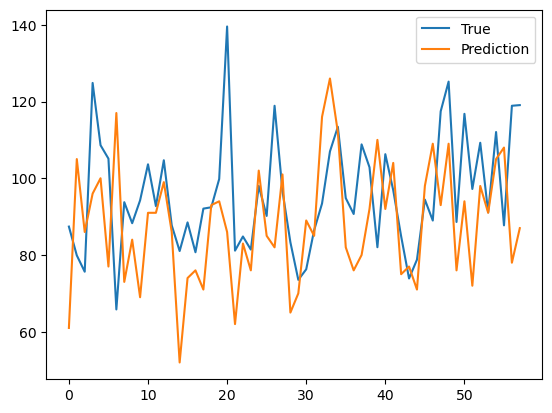

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,r2_score,root_mean_squared_error

model_lr = LinearRegression()
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

model_rf.fit(X_train,y_train)
y_val_pred = model_rf.predict(X_valid)
print(mean_absolute_error(y_valid,y_val_pred))
print(root_mean_squared_error(y_valid,y_val_pred))

plt.figure()
plt.plot(y_val_pred,label='True')
plt.plot(y_valid.values,label='Prediction')
plt.legend()
plt.show()


# **4.LSTM, CNN 초기 모델**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.

In [18]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [19]:
timesteps = 7
X_train,y_train = temporalize(X_train,y_train,timesteps)
X_valid,y_valid = temporalize(X_valid,y_valid,timesteps)

In [20]:
print(X_train.shape)
X_train

(1089, 7, 2)


array([[[-2.25322845, -0.73860585],
        [-1.36333422,  0.02269492],
        [-1.43452576, -0.32583595],
        ...,
        [-0.93618499,  0.98081312],
        [-1.75488768, -0.66753289],
        [-1.29214268, -1.01469697]],

       [[-1.36333422,  0.02269492],
        [-1.43452576, -0.32583595],
        [-1.29214268,  1.27877284],
        ...,
        [-1.75488768, -0.66753289],
        [-1.29214268, -1.01469697],
        [-1.47012153, -0.20692542]],

       [[-1.43452576, -0.32583595],
        [-1.29214268,  1.27877284],
        [-0.93618499,  0.98081312],
        ...,
        [-1.29214268, -1.01469697],
        [-1.47012153, -0.20692542],
        [-1.29214268, -0.93268971]],

       ...,

       [[-1.22095114,  3.92214031],
        [-0.93618499,  5.33266525],
        [-1.07856806,  4.13399241],
        ...,
        [-1.43452576,  1.72161207],
        [-1.36333422,  0.36849221],
        [-0.93618499,  1.08058862]],

       [[-0.93618499,  5.33266525],
        [-1.07856806,  4.13

## **(1) LSTM 초기 모델링**

* **데이터 준비**

In [21]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
# LSTM 모델 정의
model = Sequential()
model.add(LSTM(units=128,return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2]))) # return_sequences = True | False 성능 동일, units=2,16,32든 모두 동일 
# model.add(LSTM(units=16,return_sequences=False)) # 추가 LSTM(unit_16) 반영 
model.add(Dense(units=1))  # 출력 노드 수는 특성의 수에 맞추어야 함 (여기서는 2개)

model.compile(optimizer=Adam(learning_rate=0.001), loss=MeanSquaredError())
es = EarlyStopping(monitor='val_loss',patience=30)
# 모델 훈련
model.fit(X_train, y_train,validation_data=[X_valid,y_valid], epochs=100, batch_size=8,callbacks=es)

# 예측
predictions = model.predict(X_valid)


Epoch 1/100
137/137 [==============================] - 5s 14ms/step - loss: 10174.0039 - val_loss: 3305.4775
Epoch 2/100
137/137 [==============================] - 1s 7ms/step - loss: 6140.6826 - val_loss: 1711.1049
Epoch 3/100
137/137 [==============================] - 1s 7ms/step - loss: 4099.2222 - val_loss: 818.0287
Epoch 4/100
137/137 [==============================] - 1s 7ms/step - loss: 2754.9595 - val_loss: 383.5924
Epoch 5/100
137/137 [==============================] - 1s 7ms/step - loss: 1899.7072 - val_loss: 243.4787
Epoch 6/100
137/137 [==============================] - 1s 8ms/step - loss: 1376.0643 - val_loss: 274.8813
Epoch 7/100
137/137 [==============================] - 1s 7ms/step - loss: 1075.8671 - val_loss: 392.3892
Epoch 8/100
137/137 [==============================] - 1s 7ms/step - loss: 914.4223 - val_loss: 529.3138
Epoch 9/100
137/137 [==============================] - 1s 7ms/step - loss: 854.5303 - val_loss: 604.1216
Epoch 10/100
137/137 [======================

In [24]:
predictions

array([[ 95.78398 ],
       [ 81.46671 ],
       [ 94.66822 ],
       [ 87.4117  ],
       [ 88.498566],
       [ 90.96542 ],
       [ 94.9858  ],
       [100.761765],
       [ 55.948135],
       [ 72.262886],
       [ 74.4124  ],
       [ 77.83684 ],
       [ 84.97134 ],
       [ 88.929115],
       [ 97.691025],
       [ 56.07143 ],
       [ 65.8513  ],
       [ 73.4086  ],
       [ 77.786064],
       [ 82.02851 ],
       [ 98.86869 ],
       [ 98.51478 ],
       [ 59.3828  ],
       [ 75.595085],
       [ 78.492516],
       [ 80.96516 ],
       [ 94.72233 ],
       [ 90.12124 ],
       [106.22738 ],
       [ 77.89912 ],
       [ 81.35825 ],
       [ 90.25014 ],
       [ 93.608894],
       [ 96.97901 ],
       [107.49221 ],
       [118.68865 ],
       [ 60.11833 ],
       [ 80.567924],
       [ 81.291   ],
       [ 85.87471 ],
       [ 89.76557 ],
       [ 98.607285],
       [106.70719 ],
       [ 76.150604],
       [ 81.53852 ],
       [ 84.67006 ],
       [ 96.92776 ],
       [102.7

* **모델링**

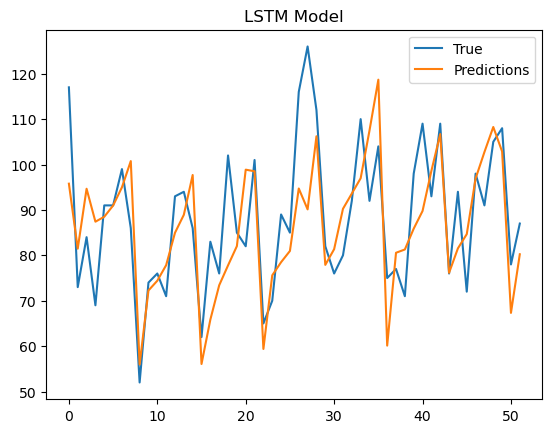

In [25]:
plt.figure()
plt.plot(y_valid,label='True')
plt.plot(predictions[:,0],label='Predictions') # 변화에 대한 반응이 느리고 예측률에 대해 너무 저조합합
plt.title("LSTM Model")
plt.legend()
plt.show()

In [26]:
mean_absolute_error(y_valid,predictions)

9.160278980548565

## **(2) CNN 초기 모델링**

### **(1) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **5.데이터 저장**

* **세부 요구사항**
    * 상품코드별 데이터셋을 저장하시오.
    * joblib.dump를 이용하시오.
    * 저장할 파일의 확장자는 보통 .pkl 입니다.